### Combine the data from several files

In [1]:
import json
import numpy as np
from scipy import stats
import itertools
from simulate import find_mean_std_mse
import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
#%matplotlib notebook
#%matplotlib inline

#play with this for better figure sizes 
mpl.rcParams['figure.figsize'] = (7,7)

In [3]:
PATH = "data_experiments/"

In [4]:
def plot_mean_and_confidence(plot_range, mean, mean_label, confidence_interval, 
                             confidence_interval_title):
    """
    Plot the mean and some kind of confidence interval (standard deviation or
    mean-squared-error)
    
    Parameters:
    ----------
    plot_range: iterable
    mean: an iterable
        the mean of the values at that point
    confidence_interval: an iterable
        Representing the  interval of confidence in that point. 
        The iterable should have length plot_range.
    confidence_interval_title: a string
    
    """
    
    lower_bound = np.array(mean)-np.array(confidence_interval)
    upper_bound = np.array(mean)+np.array(confidence_interval)
    plt.plot(plot_range, mean, label=mean_label)
    if confidence_interval_title:
        plt.fill_between(plot_range, lower_bound, upper_bound, 
                         label='{}'.format(confidence_interval_title),
                         alpha=0.2)
    else:
        plt.fill_between(plot_range, lower_bound, upper_bound, alpha=0.2)
        
        
def plot_results(*args, **kwargs):
    """plot results from simulations
    
    Parameters:
        args: 1 or more dicts. The dicts should have for the keys numerical
            input values and for the values iterables of numbers.
        kwargs: at least the arguments xlabel, ylabel, title
        
    """
    for argument in args:
        data, meta_dict = argument
        variable_range, mean, std, batches_std = (
            find_mean_std_mse(data, 10)
        )
        
        if kwargs['std_of_batches']: 
            plot_mean_and_confidence(variable_range, mean, meta_dict['mean_label'], 
                                     batches_std, "batches stdev")
        else:
            plot_mean_and_confidence(variable_range, mean, meta_dict['mean_label'], 
                                     std, "stdev")
    
    plt.xlabel(kwargs['xlabel'])
    plt.ylabel(kwargs['ylabel'])
    plt.legend()
    plt.title(kwargs['title'])
    plt.show()

### load the data for the maximum nudges

In [5]:
def dict_keys_from_string_to_int(dictionary):
    return {int(k):v for k,v in dictionary.items()}

def files_to_dict(file_names):
    """ Load the data from the files and make keys into ints"""
    dictionaries = []
    for file_name in file_names:
        with open(file_name, 'r') as f:
            dictionaries.append(json.load(f))

    dictionaries = [dict_keys_from_string_to_int(i) for i in dictionaries]
    return dictionaries

def compare_settings(value_to_scores, min_value, max_value):
    value_to_average_scores = {}
    for i in range(min_value, max_value+1, 1):
        average_impacts = []
        for count, dirichlet_dict in enumerate(value_to_scores):
            try:
                average_impacts.append(np.mean(dirichlet_dict[i]))
            except KeyError:
                print("the {} file has variable {} missing".format(i, count))

        value_to_average_scores[i] = average_impacts

    return value_to_average_scores

def flip_sign_values_dict(dictionary):
    for key, values in dictionary.items():
        dictionary[key] = [-value for value in values]
        
    return dictionary

def find_max_scores_per_value(dictionaries, min_value, max_value):
    value_to_maximum_scores = {}
    for i in range(min_value, max_value+1, 1):
        impacts = []
        for count, dictionary in enumerate(dictionaries):
            try:
                impacts.append(dictionary[i])
            except KeyError:
                print("the {} file has variable {} missing".format(i, count))

        max_impacts = [max(scores) for scores in list(zip(*impacts))]
        value_to_maximum_scores[i] = max_impacts

    return value_to_maximum_scores

### get maximum nudge impacts

In [6]:
def get_max_impacts(number_of_vars, number_of_states, percentage_max_entropy_size, 
                    nudge_type, dist_start, dist_end):
    filename_to_save_impacts =  "impacts_{}var_{}states_{}entropy_{}_nudge_dists{}-{}.json".format(
        number_of_vars, number_of_states, percentage_max_entropy_size, nudge_type, dist_start, dist_end
    )
    with open("data_experiments/" + filename_to_save_impacts, 'r') as f:
        impacts = json.load(f)
        
    return impacts



individual
2
3
4
5
6
7
local
2
3
4
5
6
7
synergistic
2
3
4
5
6
7
global
2
3
4
5
6
7


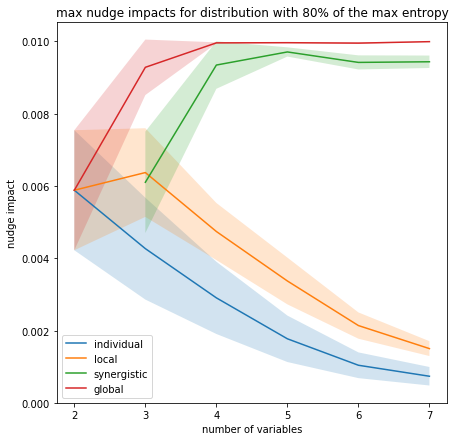

In [7]:
NUMBER_OF_STATES = 3
PERCENTAGE_MAX_ENTROPY_SIZE = 80
nudge_types = ["individual", "local", "synergistic", "global"]
numbers_of_var = [2, 3, 4, 5, 6, 7]
for nudge_type in nudge_types:
    print(nudge_type)
    var_to_impacts = {}
    for number_of_var in numbers_of_var:
        print(number_of_var)
        if nudge_type == "synergistic" and number_of_var==2:
            continue
        if nudge_type == "local" and number_of_var==2:
            impacts = get_max_impacts(
                number_of_var, NUMBER_OF_STATES, PERCENTAGE_MAX_ENTROPY_SIZE, 
                "individual", dist_start=100, dist_end=200
            )
        else:
            impacts = get_max_impacts(
                number_of_var, NUMBER_OF_STATES, PERCENTAGE_MAX_ENTROPY_SIZE, 
                nudge_type, dist_start=100, dist_end=200
            )

            if nudge_type == "local" or nudge_type == "synergistic":
                impacts = [-1*impact for impact in impacts]

        var_to_impacts[number_of_var] = impacts
        
    variable_range, mean, std, batches_std = (
        find_mean_std_mse(var_to_impacts, 10)
    )
    plot_mean_and_confidence(variable_range, mean, nudge_type, std, None)
    
plt.xlabel("number of variables")
plt.ylabel("nudge impact")
plt.title("max nudge impacts for distribution with {}% of the max entropy".format(PERCENTAGE_MAX_ENTROPY_SIZE))
plt.legend()
plt.show()



### Get random nudge impacts

### First inspect the local maximum nudges

In [ ]:
print("inspect local dirichlet file")
average_scores_per_file_local_dirichlet = compare_settings(local_dirichlet_dicts, min_value=2, max_value=5)
print("inspect local entropy 75 file")
average_scores_per_file_local_entropy75 = compare_settings(local_entropy75_dicts, min_value=2, max_value=5)

print("the max local nudge impacts per file for dirichlet inputs")
print(average_scores_per_file_local_dirichlet)
print("")

print("the max local nudge impacts per file for entropy 75 inputs")
print(average_scores_per_file_local_entropy75)


### inspect maximal synergistic nudges

In [ ]:
print("inspect synergistic dirichet file")
average_scores_per_file_synergistic_dirichlet = compare_settings(
    synergistic_dirichlet_dicts, min_value=2, max_value=6
)
print("inspect synergistic entropy 75 file")
average_scores_per_file_synergistic_entropy75 = compare_settings(
    synergistic_entropy75_dicts, min_value=2, max_value=6
)

print("the max synergistic nudge impacts per file for dirichlet inputs")
print(average_scores_per_file_synergistic_dirichlet)
print("")

print("the max synergistic nudge impacts per file for entropy 75 inputs")
print(average_scores_per_file_synergistic_entropy75)


In [ ]:
max_local_dirichlet_dict = find_max_scores_per_value(local_dirichlet_dicts, min_value=2, max_value=5)
max_local_entropy75_dict = find_max_scores_per_value(local_entropy75_dicts, min_value=2, max_value=5)
max_synergistic_dirichlet_dict = find_max_scores_per_value(synergistic_dirichlet_dicts, min_value=2, max_value=6)
max_synergistic_entropy75_dict = find_max_scores_per_value(synergistic_entropy75_dicts, min_value=2, max_value=6)

In [ ]:
plot_range_local_dirichlet, mean_local_dirichlet, std_local_dirichlet, batches_std_local_dirichlet = (
    find_mean_std_mse(max_local_dirichlet_dict, batch_size=10)
)
plot_range_local_entropy75, mean_local_entropy75, std_local_entropy75, batches_std_local_entropy75 = (
    find_mean_std_mse(max_local_entropy75_dict, batch_size=1)
)
plot_range_synergistic_dirichlet, mean_synergistic_dirichlet, std_synergistic_dirichlet, batches_std_synergistic_dirichlet = (
    find_mean_std_mse(max_synergistic_dirichlet_dict, batch_size=10)
)
plot_range_synergistic_entropy75, mean_synergistic_entropy75, std_synergistic_entropy75, batches_std_synergistic_entropy75 = (
    find_mean_std_mse(max_synergistic_entropy75_dict, batch_size=10)
)
plot_range_individual_dirichlet, mean_individual_dirichlet, std_individual_dirichlet, batches_std_individual_dirichlet = (
    find_mean_std_mse(individual_dirichlet_dict, batch_size=10)
)
plot_range_individual_entropy75, mean_individual_entropy75, std_individual_entropy75, batches_std_individual_entropy75 = (
    find_mean_std_mse(individual_entropy75_dict, batch_size=10)
)
plot_range_global_dirichlet, mean_global_dirichlet, std_global_dirichlet, batches_std_global_dirichlet = (
    find_mean_std_mse(global_dirichlet_dict, batch_size=10)
)
plot_range_global_entropy75, mean_global_entropy75, std_global_entropy75, batches_std_global_entropy75 = (
    find_mean_std_mse(global_dirichlet_dict, batch_size=10)
)





In [ ]:

mpl.legend.loc = "upper_left"

plt.plot(plot_range_local_dirichlet, mean_local_dirichlet, label="local")
plt.plot(plot_range_synergistic_dirichlet, mean_synergistic_dirichlet, label="synergistic")
plt.plot(plot_range_individual_dirichlet, mean_individual_dirichlet, label="individual")
plt.plot(plot_range_global_dirichlet, mean_global_dirichlet, label="global")

lower_bound_synergistic_dirichlet = np.array(mean_synergistic_dirichlet)-np.array(std_synergistic_dirichlet)
upper_bound_synergistic_dirichlet = np.array(mean_synergistic_dirichlet)+np.array(std_synergistic_dirichlet)
plt.fill_between(plot_range_synergistic_dirichlet, lower_bound_synergistic_dirichlet, 
                 upper_bound_synergistic_dirichlet, 
                 alpha=0.2)

lower_bound_individual_dirichlet = np.array(mean_individual_dirichlet)-np.array(std_individual_dirichlet)
upper_bound_individual_dirichlet = np.array(mean_individual_dirichlet)+np.array(std_individual_dirichlet)
plt.fill_between(plot_range_individual_dirichlet, lower_bound_individual_dirichlet, 
                 upper_bound_individual_dirichlet, 
                 alpha=0.2)

lower_bound_global_dirichlet = np.array(mean_global_dirichlet)-np.array(std_global_dirichlet)
upper_bound_global_dirichlet = np.array(mean_global_dirichlet)+np.array(std_global_dirichlet)
plt.fill_between(plot_range_global_dirichlet, lower_bound_global_dirichlet, upper_bound_global_dirichlet, 
                 alpha=0.2)

lower_bound_local_dirichlet = np.array(mean_local_dirichlet)-np.array(std_local_dirichlet)
upper_bound_local_dirichlet = np.array(mean_local_dirichlet)+np.array(std_local_dirichlet)
plt.fill_between(plot_range_local_dirichlet, lower_bound_local_dirichlet, upper_bound_local_dirichlet, 
                 alpha=0.2)

plt.legend(loc="upper left")
plt.show()




# lower_bound_random_control = np.array(mean_random_control)-np.array(std_random_control)
# upper_bound_random_control = np.array(mean_random_control)+np.array(std_random_control)
# plt.fill_between(plot_range, lower_bound_random_control, upper_bound_random_control, 
#                  label='{}'.format("random control std"), alpha=0.2)




In [ ]:
plt.plot(plot_range_local_entropy75, mean_local_entropy75, label="local")
plt.plot(plot_range_synergistic_entropy75, mean_synergistic_entropy75, label="synergistic")
plt.plot(plot_range_individual_entropy75, mean_individual_entropy75, label="individual")
plt.plot(plot_range_global_entropy75, mean_global_entropy75, label="global")

lower_bound_synergistic_entropy75 = np.array(mean_synergistic_entropy75)-np.array(std_synergistic_entropy75)
upper_bound_synergistic_entropy75 = np.array(mean_synergistic_entropy75)+np.array(std_synergistic_entropy75)
plt.fill_between(plot_range_synergistic_entropy75, lower_bound_synergistic_entropy75, 
                 upper_bound_synergistic_entropy75, 
                 label='{}'.format("random local std"), alpha=0.2)

lower_bound_individual_entropy75 = np.array(mean_individual_entropy75)-np.array(std_individual_entropy75)
upper_bound_individual_entropy75 = np.array(mean_individual_entropy75)+np.array(std_individual_entropy75)
plt.fill_between(plot_range_individual_entropy75, lower_bound_individual_entropy75, 
                 upper_bound_individual_entropy75, 
                 label='{}'.format("random local std"), alpha=0.2)

lower_bound_global_entropy75 = np.array(mean_global_entropy75)-np.array(std_global_entropy75)
upper_bound_global_entropy75 = np.array(mean_global_entropy75)+np.array(std_global_entropy75)
plt.fill_between(plot_range_global_entropy75, lower_bound_global_entropy75, upper_bound_global_entropy75, 
                 label='{}'.format("random local std"), alpha=0.2)

lower_bound_local_entropy75 = np.array(mean_local_entropy75)-np.array(std_local_entropy75)
upper_bound_local_entropy75 = np.array(mean_local_entropy75)+np.array(std_local_entropy75)
plt.fill_between(plot_range_local_entropy75, lower_bound_local_entropy75, upper_bound_local_entropy75, 
                 label='{}'.format("random local std"), alpha=0.2)

#plt.legend()
plt.show()


### Combine data experiment impact on MI of minimalizing individual nudge impact

In [ ]:
def load_files_json(file_names):
    dicts = []
    for file_name in file_names:
        with open(file_name, 'r') as f:
            dicts.append(json.load(f))
            
    return dicts

def update_dictkeys_unicode2string(dictionary):
    return {str(k):v for k,v in dictionary.items()}

def combine_data_dicts(dictionaries):
    """
    Combine data dicts, meaning that all data of the same key are merged into a new dict
    
    Parameters:
    ----------
    dictionaries: a list of dicts
        Every key of the dicts should have a list as values 

    """
    new_dict = {}
    for dictionary in dictionaries:
        for key, values in dictionary.items():
            if key in new_dict:
                new_dict[key].extend(values)
            else:
                new_dict[key] = values
                
    return new_dict

def get_average_values_dict(dictionary):
    """take average of all values dictionary"""
    return {k:np.mean(v) for k, v in dictionary.items()}

#for 2 input vars with 5 states
file_name_format2 = "minimize_individual_focused_nudge_impact_kl_divergence_inspect_change_MI_2var_5states{}.json"
files_vars2 = [PATH + file_name_format2.format(i) for i in ["", 1, 3, 4, 5, 6]]
dictionaries_vars2 = load_files_json(files_vars2)
dictionaries_vars2 = [update_dictkeys_unicode2string(dictionary) for dictionary in dictionaries_vars2]
dictionary_vars2 = combine_data_dicts(dictionaries_vars2)
print(get_average_values_dict(dictionary_vars2))

#for 3 input vars with 5 states
file_name_format3 = "minimize_individual_focused_nudge_impact_inspect_change_MI_3var_5states{}.json"
files_vars3 = [PATH + file_name_format3.format(i) for i in ["", 2, 3, 4, 5]]
dictionaries_vars3 = load_files_json(files_vars3)
dictionaries_vars3 = [update_dictkeys_unicode2string(dictionary) for dictionary in dictionaries_vars3]
dictionary_vars3 = combine_data_dicts(dictionaries_vars3)
print(get_average_values_dict(dictionary_vars3))

file_vars4 = "minimize_individual_focused_nudge_impact_inspect_change_MI_4var_5states.json"
dictionaries_vars4 = load_files_json([PATH + file_vars4])
dictionary_vars4 = update_dictkeys_unicode2string(dictionaries_vars4[0])
print(get_average_values_dict(dictionary_vars4))

### Correlation MI and individual nudge impact

In [ ]:
def load_data_correlation_MI_nudge_impact(var_to_file_names):
    """
    Parameters:
    ----------
    var_to_files: a dict
    
    """
    var_to_MI_and_nudge_impact = {}
    for number_of_var, file_names in var_to_file_names.items():
        file_names = [PATH+file_name for file_name in file_names]
        if number_of_var == 5:
            mi_and_nudge_impact_lists = load_files_json(file_names)
            var_to_MI_and_nudge_impact[number_of_var] = [
                list(itertools.chain.from_iterable(mi_and_nudge_impact_lists))
            ]
        else:
            var_to_MI_and_nudge_impact[number_of_var] = load_files_json(file_names)[0]

    return var_to_MI_and_nudge_impact

focused_nudge_kl_divergence_impact_and_MI_var_to_files = {
    1: ["correlation_MI_individual_nudge_impact_1var_5states_min_output001_ex1.json"],
    2: ["correlation_MI_individual_nudge_impact_2var_5states_min_output001_ex2.json"],
    3: ["correlation_MI_individual_nudge_impact_3var_5states_min_output001_exp3.json"],
    4: ["correlation_MI_individual_nudge_impact_4var_5states_min_output001_exp4.json"],
    5: [
        "correlation_MI_individual_nudge_impact_5var_5states_min_output001_exp5_points0_20.json",
        "correlation_MI_individual_nudge_impact_5var_5states_min_output001_exp6_point20_40.json",
        "correlation_MI_individual_nudge_impact_5var_5states_min_output001_exp3_points40_60.json",
        "correlation_MI_individual_nudge_impact_5var_5states_min_output001_ex2_points60_80.json",
        "correlation_MI_individual_nudge_impact_5var_5states_min_output001_ex1_points80_100.json"
    ]
}

focused_nudge_l1norm_impact_and_MI_var_to_files = {
    1: ["correlation_MI_individual_nudge_impact_1var_5states_l1norm_ex1.json"],
    2: ["correlation_MI_individual_nudge_impact_2var_5states_l1norm_ex2.json"],
    3: ["correlation_MI_individual_nudge_impact_3var_5states_l1norm_exp3.json"],
    4: ["correlation_MI_individual_nudge_impact_4var_5states_l1norm_exp4.json"],
    5: [
        "correlation_MI_individual_nudge_impact_5var_5states_l1norm_exp5_points0_20.json",
        "correlation_MI_individual_nudge_impact_5var_5states_l1norm_exp6_point20_40.json",
        "correlation_MI_individual_nudge_impact_5var_5states_l1norm_ex1_points40_60.json",
        "correlation_MI_individual_nudge_impact_5var_5states_l1norm_ex2_points60_80.json"
    ]
}

vector_nudge_kl_divergence_impact_and_MI_var_to_files = {
    1: ["correlation_MI_individual_vector_nudge_impact_1var_5states_min_output001_ex1.json"],
    2: ["correlation_MI_individual_vector_nudge_impact_2var_5states_kl-divergence_ex2.json"],
    3: ["correlation_MI_individual_vector_nudge_impact_3var_5states_kl-divergence_ex1.json"],
    4: ["correlation_MI_individual_vector_nudge_impact_4var_5states_kl-divergence_ex2.json"],
    5: [
        "correlation_MI_individual_vector_nudge_impact_5var_5states_kl-divergence_ex3_points0_30.json",
        "correlation_MI_individual_vector_nudge_impact_5var_5states_kl-divergence_ex1_points30_60.json"
    ]
}

vector_nudge_l1norm_impact_and_MI_var_to_files = {
    1: ["correlation_MI_individual_vector_nudge_impact_1var_5states_l1norm_ex1.json"],
    2: ["correlation_MI_individual_vector_nudge_impact_2var_5states_l1norm_ex2.json"],
    3: ["correlation_MI_individual_vector_nudge_impact_3var_5states_l1norm_ex3.json"],
    4: ["correlation_MI_individual_vector_nudge_impact_4var_5states_l1norm_ex4.json"],
    5: [
        "correlation_MI_individual_vector_nudge_impact_5var_5states_l1norm_ex5_point0_30.json",
        "correlation_MI_individual_vector_nudge_impact_5var_5states_l1norm_exp6_points30_60.json",
        "correlation_MI_individual_vector_nudge_impact_5var_5states_l1norm_ex5_point60_90.json",
        "correlation_MI_individual_vector_nudge_impact_5var_5states_l1norm_exp6_points90_120.json"
    ]
}

var_to_focused_nudge_kl_divergence_impact_and_MI = load_data_correlation_MI_nudge_impact(
    focused_nudge_kl_divergence_impact_and_MI_var_to_files
)

var_to_focused_nudge_l1norm_impact_and_MI = load_data_correlation_MI_nudge_impact(
    focused_nudge_l1norm_impact_and_MI_var_to_files
)

var_to_vector_nudge_kl_divergence_impact_and_MI = load_data_correlation_MI_nudge_impact(
    vector_nudge_kl_divergence_impact_and_MI_var_to_files
)

var_to_vector_nudge_l1norm_impact_and_MI = load_data_correlation_MI_nudge_impact(
    focused_nudge_kl_divergence_impact_and_MI_var_to_files
)



In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

#### Plot correlations

In [ ]:
#import seaborn as sns
#add seaborn linregress on own computer

dict_to_use = var_to_focused_nudge_kl_divergence_impact_and_MI
# dict_to_use = var_to_focused_nudge_l1norm_impact_and_MI
# dict_to_use = var_to_vector_nudge_kl_divergence_impact_and_MI
# dict_to_use = var_to_vector_nudge_l1norm_impact_and_MI

for var, impact_nudges_and_mi in dict_to_use.items():
    if var == 5:
        impact_nudges_and_mi=impact_nudges_and_mi[0]

    impact_nudges = [item[0] for item in impact_nudges_and_mi] 
    mutual_information_sizes = [item[1] for item in impact_nudges_and_mi]
        
    plt.plot(mutual_information_sizes, impact_nudges, 'o')
    plt.xlabel("mutual information")
    plt.ylabel("nudge impact")
    plt.show()
    print(stats.linregress(impact_nudges, mutual_information_sizes))


In [ ]:
import seaborn as sns
import pandas as pd

# dict_to_use = var_to_focused_nudge_kl_divergence_impact_and_MI
# dict_to_use = var_to_focused_nudge_l1norm_impact_and_MI
# dict_to_use = var_to_vector_nudge_kl_divergence_impact_and_MI
dict_to_use = var_to_vector_nudge_l1norm_impact_and_MI

for var, impact_nudges_and_mi in dict_to_use.items():
    if var == 5:
        impact_nudges_and_mi = impact_nudges_and_mi[0]       
    else:
        impact_nudges = [item[0] for item in impact_nudges_and_mi] 
        mutual_information_sizes = [item[1] for item in impact_nudges_and_mi]

    
    df = pd.DataFrame({"nudge impact": impact_nudges, "mutual information": mutual_information_sizes}) 
    sns.regplot("nudge impact", "mutual information", df)
    sns.plt.show()
    print(stats.linregress(impact_nudges, mutual_information_sizes))


#### Relation MI and nudge impact for 1 input and 1 output 

In [ ]:
with open("data_experiments/relation_MI_nudge_impact_1input_non_biased1.json", 'r') as f:
    data_dict = json.load(f)

with open("data_experiments/relation_MI_nudge_impact_1input_non_biased2.json", 'r') as f:
    data_dict1 = json.load(f)
    
for mi_value, values in data_dict1.items():
    data_dict1[round((float(mi_value)*1000.0))/1000.0] = values
    data_dict1.pop(mi_value, None)
    
for mi_value, values in data_dict.items():
    data_dict[round((float(mi_value)*100.0))/100.0] = values
    data_dict.pop(mi_value, None)
    
data_dict.update(data_dict1)

In [ ]:
print({k:len(v) for k,v in data_dict.items()})
plot_range, mean, std, batches_std = find_mean_std_mse(data_dict, batch_size=1)
print(np.array(data_dict[0.85]))

In [ ]:
lower_bound = np.array(mean)-np.array(std)
upper_bound = np.array(mean)+np.array(std)
print(lower_bound)
print(upper_bound)
print(plot_range)
plt.plot(plot_range, mean, label="mean")
plt.fill_between(plot_range, lower_bound, upper_bound, 
                 label='{}'.format("std"),
                 alpha=0.2)

plt.xlabel("mutual information")
plt.ylabel("KL-divergence")
#plt.legend()
plt.title('Individual nudge impact for set mutual information')
plt.show()

stats.linregress(np.array(plot_range), np.array(mean))